<a href="https://colab.research.google.com/github/alecbidaran/Designing-an-AI-assisted-toolbox-for-fitness-activity-recognition-based-on-deep-CNN/blob/main/fully_conected_UCF101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import numpy as np
from PIL import ImageFile
import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
ImageFile.LOAD_TRUNCATED_IMAGES = True
import functools
import os
import pandas as pd
#tf.compat.v1.disable_eager_execution()
import time

In [ ]:
optical_dense='/content/drive/My Drive/datasets/traindofl=10'
RGB='/content/drive/My Drive/datasets/RGB'
valid_rgb='/content/drive/My Drive/datasets/valid_RGB'
test_dence='/content/drive/My Drive/datasets/test_dence'
test='/content/drive/My Drive/datasets/test'
test_rgb='/content/drive/My Drive/datasets/test_RGB (1)'
test_dof1='/content/drive/My Drive/datasets/dof_test'

In [ ]:
train_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=0.2,validation_split=0.2,horizontal_flip=True)
test_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2,horizontal_flip=True)
test1_datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True)

In [ ]:
aug_path='/content/aug_RGB_test/'
aug_flow_path='/content/aug_flow_test'

In [ ]:
train_dense_batch=train_datagen.flow_from_directory(optical_dense, target_size=(224, 224), color_mode='rgb', classes=None, class_mode='categorical', batch_size=16,shuffle=False, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset='training')
train_RGB_batch=train_datagen.flow_from_directory(RGB, target_size=(224, 224), color_mode='rgb', classes=None, class_mode='categorical', batch_size=16, seed=None,shuffle=False, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset='training')
test_batch=test1_datagen.flow_from_directory(test_rgb, target_size=(224, 224), color_mode='rgb', classes=None,shuffle=False, class_mode='categorical', batch_size=16, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None)
test_dense=test_datagen.flow_from_directory(test_dof1, target_size=(224, 224), color_mode='rgb', classes=None, class_mode=None, batch_size=32, shuffle=False, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None)


Found 6968 images belonging to 7 classes.
Found 7838 images belonging to 7 classes.
Found 2091 images belonging to 7 classes.
Found 1594 images belonging to 7 classes.


In [ ]:
7838/7

1119.7142857142858

In [ ]:
test_batch.class_indices

{'benchpress': 0,
 'bodysquat': 1,
 'handoushup': 2,
 'jumpingjacks': 3,
 'lunges': 4,
 'pullups': 5,
 'pushups': 6}

In [ ]:
pretrained_model=keras.applications.MobileNet(input_shape=(224,224,3),include_top=False,weights='imagenet')
def create_model():
  base=pretrained_model
  flatten=keras.layers.Flatten()(base.output)
  Dense1=keras.layers.Dense(1024,activation='relu',kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(flatten)
  dropout=keras.layers.Dropout(0.5)(Dense1)
  classification=keras.layers.Dense(7,activation="softmax",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5,l2=1e-4))(dropout)
  model=keras.models.Model(inputs=base.inputs,outputs=classification)
  return model
dense_mobilenet=create_model()
rgb_mobilenet=create_model()
for layer in pretrained_model.layers:
    layer.trainable=False
rgb_mobilenet.load_weights("/content/drive/My Drive/nets/RGBucfmobilenet.h5")
dense_mobilenet.load_weights("/content/drive/My Drive/nets/flowucfmobilenet.h5")


17227776/17225924 [==============================] - 0s 0us/step


In [ ]:
keras.backend.clear_session()
top5acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=5)
top5acc.__name__="top5acc"
top1acc=functools.partial(keras.metrics.top_k_categorical_accuracy,k=1)
top1acc.__name__="top1acc"
rgb_mobilenet.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9,decay=1e-3/30),metrics=[top5acc,top1acc])
dense_mobilenet.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.SGD(learning_rate=1e-3,momentum=0.9,decay=1e-3/30),metrics=[top5acc,top1acc])

In [ ]:
rgb_mobilenet.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

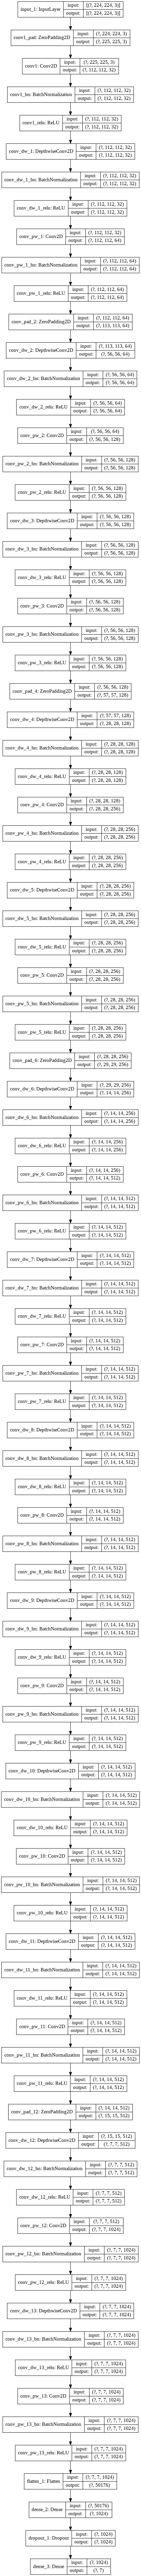

In [ ]:
tf.keras.utils.plot_model(rgb_mobilenet,to_file='rgbmobilenet.png',
                          show_shapes=True,
                          expand_nested=False)

In [ ]:
RGB_train=rgb_mobilenet.predict(train_RGB_batch,workers=16)

In [ ]:
flow_train=dense_mobilenet.predict(train_dense_batch,workers=16)

In [ ]:
RGB_train

array([[1.0000000e+00, 2.3664425e-14, 6.6781209e-14, ..., 1.5441965e-11,
        1.1679588e-16, 2.5886428e-15],
       [1.0000000e+00, 1.9479520e-15, 1.0736618e-12, ..., 3.9177060e-13,
        6.1386020e-17, 2.0113885e-16],
       [1.0000000e+00, 2.2499272e-15, 2.4868183e-13, ..., 1.5581045e-11,
        1.4477315e-17, 3.2842924e-16],
       ...,
       [5.1177544e-14, 7.4830075e-14, 6.5080276e-13, ..., 5.2233164e-13,
        4.3460251e-14, 1.0000000e+00],
       [3.0001248e-11, 7.5842732e-16, 1.4417189e-17, ..., 5.3347262e-20,
        5.0631031e-21, 1.0000000e+00],
       [7.9036690e-12, 6.9524703e-10, 3.0501183e-16, ..., 2.3865575e-19,
        1.7176993e-21, 1.0000000e+00]], dtype=float32)

flow lenght:
bench_press=[:1000]
bodysquat=[1100:2100]
handpush=[2200:3200]
jj=[3300:4300]
lunge=[4400:5000]
pull=[5100:6000]
push=[6000:6900]


RGB_length:
bench_press:[:1000]
bodysquat=[1200:2200]
hand_pushups=[2200:3200]
jj=[3200:4200]
lunge=[4400:4400+900]
pullups=[5400:5400+900]
pushups=[6500:6500+900]





In [ ]:
train_RGB_batch.classes[6500:6500+900]

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,

In [ ]:
rgb0=RGB_train[:1000]
rgb1=RGB_train[1200:2200]
rgb2=RGB_train[2200:3200]
rgb3=RGB_train[3200:4200]
rgb4=RGB_train[4400:4400+600]
rgb5=RGB_train[5400:5400+900]
rgb6=RGB_train[6500:6500+900]

In [ ]:
flow0=flow_train[:1000]
flow1=flow_train[1100:2100]
flow2=flow_train[2200:3200]
flow3=flow_train[3300:4300]
flow4=flow_train[4400:5000]
flow5=flow_train[5100:6000]
flow6=flow_train[6000:6900]


In [ ]:
len(flow4)

600

In [ ]:
con0=np.concatenate([rgb0,flow0],axis=1)
con1=np.concatenate([rgb1,flow1],axis=1)
con2=np.concatenate([rgb2,flow2],axis=1)
con3=np.concatenate([rgb3,flow3],axis=1)
con4=np.concatenate([rgb4,flow4],axis=1)
con5=np.concatenate([rgb5,flow5],axis=1)
con6=np.concatenate([rgb6,flow6],axis=1)

In [ ]:
train_fuse=np.vstack([
                      con0,con1,
                      con2,con3,
                      con4,con5,
                      con6

])

In [ ]:
train_fuse.shape

(6400, 14)

In [ ]:
classes=tf.keras.utils.to_categorical(train_dense_batch.classes)

In [ ]:
label0=classes[:1000]
label1=classes[1100:2100]
label2=classes[2200:3200]
label3=classes[3300:4300]
label4=classes[4400:5000]
label5=classes[5100:6000]
label6=classes[6000:6900]

In [ ]:
train_labels=np.vstack([
                        label0,label1,
                        label2,label3,
                        label4,label5,
                        label6

])

In [ ]:
train_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
fused_model=tf.keras.models.Sequential([
                                        keras.layers.Input(shape=(14,)),
                                        keras.layers.Dense(12,activation='sigmoid'),
                                        keras.layers.Dense(7,activation='softmax')
])

In [ ]:
fused_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 91        
Total params: 271
Trainable params: 271
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tf.keras.utils.model_to_dot(
    fused_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    subgraph=False,
)

In [ ]:
fused_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping=tf.keras.callbacks.EarlyStopping(min_delta=0.1,patience=5,restore_best_weights=True)
callbacks=[early_stopping]

In [ ]:
history=fused_model.fit(train_fuse,train_labels,validation_split=0.2,batch_size=16,epochs=20,callbacks=callbacks)

Epoch 1/20
320/320 [==============================] - 1s 2ms/step - loss: 5.2666e-04 - accuracy: 0.9998 - val_loss: 8.0337 - val_accuracy: 0.2945
Epoch 2/20
320/320 [==============================] - 1s 2ms/step - loss: 7.3242e-06 - accuracy: 1.0000 - val_loss: 8.3329 - val_accuracy: 0.2945
Epoch 3/20
320/320 [==============================] - 1s 2ms/step - loss: 4.1324e-06 - accuracy: 1.0000 - val_loss: 8.5141 - val_accuracy: 0.2945
Epoch 4/20
320/320 [==============================] - 1s 2ms/step - loss: 2.7262e-06 - accuracy: 1.0000 - val_loss: 8.6491 - val_accuracy: 0.2945
Epoch 5/20
320/320 [==============================] - 1s 2ms/step - loss: 1.9616e-06 - accuracy: 1.0000 - val_loss: 8.7643 - val_accuracy: 0.2945
Epoch 6/20
320/320 [==============================] - 1s 2ms/step - loss: 1.4378e-06 - accuracy: 1.0000 - val_loss: 8.8708 - val_accuracy: 0.2945


Text(0.5, 0, 'number of epochs')

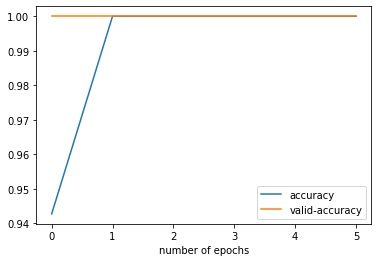

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='valid-accuracy')
plt.legend()
plt.xlabel("number of epochs")

Text(0.5, 0, 'number of epochs')

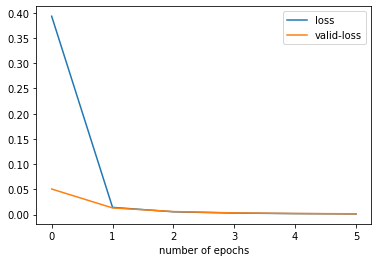

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='valid-loss')
plt.legend()
plt.xlabel("number of epochs")

In [ ]:
def load_image(path):
  img=keras.preprocessing.image.load_img(path,interpolation='bilinear',target_size=(224,224))
  img_arr=keras.preprocessing.image.img_to_array(img)/255
  img_arr=tf.expand_dims(img_arr,0)
  return img_arr

In [ ]:
test_batch.class_indices

{'benchpress': 0,
 'bodysquat': 1,
 'handoushup': 2,
 'jumpingjacks': 3,
 'lunges': 4,
 'pullups': 5,
 'pushups': 6}

In [ ]:
test_dense.class_indices

{'benchpress': 0,
 'bodysquat': 1,
 'handspushup': 2,
 'jumpjacks': 3,
 'lunge': 4,
 'pullups': 5,
 'pushups': 6}

In [ ]:
image_path=os.listdir('/content/drive/My Drive/datasets/test_RGB (1)/handoushup')
image_path[100:120]

['handspushup2339 (1).jpg',
 'handspushup2335 (1).jpg',
 'handspushup2334 (1).jpg',
 'handspushup2333 (1).jpg',
 'handspushup2332 (1).jpg',
 'handspushup2336 (1).jpg',
 'handspushup2338 (1).jpg',
 'handspushup2337 (1).jpg',
 'handspushup234 (1).jpg',
 'handspushup2340 (1).jpg',
 'handspushup2343 (1).jpg',
 'handspushup2341 (1).jpg',
 'handspushup2342 (1).jpg',
 'handspushup2346 (1).jpg',
 'handspushup2344 (1).jpg',
 'handspushup2345 (1).jpg',
 'handspushup2347 (1).jpg',
 'handspushup235 (1).jpg',
 'handspushup2348 (1).jpg',
 'handspushup2349 (1).jpg']

In [ ]:
flow_path=os.listdir('/content/drive/My Drive/datasets/dof_test/handspushup')
flow_path[20:40]


['handspushup2353.jpg',
 'handspushup2356.jpg',
 'handspushup2354.jpg',
 'handspushup2355.jpg',
 'handspushup2360.jpg',
 'handspushup2357.jpg',
 'handspushup237.jpg',
 'handspushup2366.jpg',
 'handspushup2362.jpg',
 'handspushup2371.jpg',
 'handspushup2373.jpg',
 'handspushup325.jpg',
 'handspushup311.jpg',
 'handspushup238.jpg',
 'handspushup239.jpg',
 'handspushup318.jpg',
 'handspushup324.jpg',
 'handspushup330.jpg',
 'handspushup333.jpg',
 'handspushup331.jpg']

In [ ]:
t1=time.clock()
preds1=[]
for image in image_path[100:120]:
  rgb_image=load_image('/content/drive/My Drive/datasets/test_RGB (1)/handoushup/'+image)
  predict1=rgb_mobilenet.predict(rgb_image,workers=16)
  preds1.append(predict1)
preds1=np.array(preds1)
preds1=preds1.reshape([preds1.shape[0]*preds1.shape[1],preds1.shape[2]])
t2=time.clock()
print(t2-t1)

1.2358209999999872


In [ ]:
t1=time.clock()
preds2=[]
for image in flow_path[20:40]:
  rgb_image=load_image('/content/drive/My Drive/datasets/dof_test/handspushup/'+image)
  predict2=dense_mobilenet.predict(rgb_image,workers=16)
  preds2.append(predict2)
preds2=np.array(preds2)
preds2=preds2.reshape([preds1.shape[0]*preds2.shape[1],preds2.shape[2]])
t2=time.clock()

In [ ]:
print(t2-t1)

1.1440339999999765


In [ ]:
t1=time.clock()
con0_test=np.concatenate([preds1,preds2],axis=1)
fused=fused_model.predict(con0_test)
t2=time.clock()
print(t2-t1)

0.06312199999996437


In [ ]:
fused=fused[fused[:,2]>0.2]
np.mean(fused[:,2])

0.9834238

In [ ]:
bench_press=[0.99,0.85,0.94]
body_squat=[0.88,0.97,0.85]
handspush=[0.99,0.98,0.99]
jj=[0.96,0.94,0.77]
lunge=[0.85,0.91,0.84]
pullups=[0.98,0.99,0.88]
pushups=[0.99,0.98,0.99]


In [ ]:
mean0=np.mean(bench_press)
mean1=np.mean(body_squat)
mean2=np.mean(handspush)
mean3=np.mean(jj)
mean4=np.mean(lunge)
mean5=np.mean(pullups)
mean6=np.mean(pushups)

In [ ]:
np.mean([mean0,mean1,mean2,mean3,mean4,mean5,mean6])

0.9295238095238095

In [ ]:
split1=np.mean([0.99,0.88,0.99,0.96,0.85,0.98,0.99])
split2=np.mean([0.85,0.97,0.98,0.94,0.91,0.99,0.98])
split3=np.mean([0.94,0.85,0.99,0.77,0.84,0.88,0.99])

In [ ]:
avg=np.mean([split1,split2,split3])

In [ ]:
np.mean(preds1[:,2])

0.9120844

In [ ]:
MOS={
    'Test split1':[split1],
     'Test split2':[split2],
     'Test split3':[split3],
     'Average':[avg]
}

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame.from_dict(MOS)

,Test split1,Test split2,Test split3,Average
0,0.948571,0.945714,0.894286,0.929524


# seprate Networks

In [ ]:
image_path=os.listdir('/content/drive/My Drive/datasets/test_RGB (1)/pushups')
image_path[240:280]

['pushups8-134 (1).jpg',
 'pushups8-126 (1).jpg',
 'pushups8-127 (1).jpg',
 'pushups8-128 (1).jpg',
 'pushups8-129 (1).jpg',
 'pushups8-130 (1).jpg',
 'pushups8-13 (1).jpg',
 'pushups8-131 (1).jpg',
 'pushups8-132 (1).jpg',
 'pushups8-133 (1).jpg',
 'pushups8-135 (1).jpg',
 'pushups8-139 (1).jpg',
 'pushups8-138 (1).jpg',
 'pushups8-137 (1).jpg',
 'pushups8-136 (1).jpg',
 'pushups8-14 (1).jpg',
 'pushups8-140 (1).jpg',
 'pushups8-143 (1).jpg',
 'pushups8-141 (1).jpg',
 'pushups8-142 (1).jpg',
 'pushups8-144 (1).jpg',
 'pushups8-15 (1).jpg',
 'pushups8-147 (1).jpg',
 'pushups8-146 (1).jpg',
 'pushups8-149 (1).jpg',
 'pushups8-148 (1).jpg',
 'pushups8-145 (1).jpg',
 'pushups8-150 (1).jpg',
 'pushups8-152 (1).jpg',
 'pushups8-151 (1).jpg',
 'pushups8-154 (1).jpg',
 'pushups8-153 (1).jpg',
 'pushups8-155 (1).jpg',
 'pushups8-159 (1).jpg',
 'pushups8-156 (1).jpg',
 'pushups8-157 (1).jpg',
 'pushups8-158 (1).jpg',
 'pushups8-161 (1).jpg',
 'pushups8-160 (1).jpg',
 'pushups8-16 (1).jpg']

In [ ]:
preds1=[]
for image in image_path[240:280]:
  rgb_image=load_image('/content/drive/My Drive/datasets/test_RGB (1)/pushups/'+image)
  predict1=rgb_mobilenet.predict(rgb_image,workers=16)
  preds1.append(predict1)
preds1=np.array(preds1)
preds1=preds1.reshape([preds1.shape[0]*preds1.shape[1],preds1.shape[2]])

In [ ]:
#preds1=preds1[preds1[:,4]>0.1]
np.mean(preds1[:,6])

1.0

In [ ]:
action0=[0.99,0.99,0.99]
action1=[0.99,0.98,0.78]
action2=[0.76,0.74,0.65]
action3=[0.86,0.73,0.58]
action4=[0.97,0.60,0.2]
action5=[0.99,0.99,0.89]
action6=[0.99,0.95,0.58]

In [ ]:
rgb_split3=np.mean([0.99,0.78,0.65,0.58,0.2,0.89,0.58])
rgb_split2=np.mean([0.99,0.98,0.74,0.73,0.60,0.99,0.95])
rgb_split1=np.mean([0.99,0.99,0.76,0.86,0.97,0.99,0.99])

In [ ]:
rgb_avg=np.mean([rgb_split1,rgb_split2])

In [ ]:
rgb_avg

0.895

In [ ]:
rgb_MOS={
    'Test split1':[rgb_split1],
     'Test split2':[rgb_split2],
     'Average':[rgb_avg]
}
rgb_MOS

{'Average': [0.895],
 'Test split1': [0.9357142857142858],
 'Test split2': [0.8542857142857143]}

In [ ]:
flow_path=os.listdir('/content/drive/My Drive/datasets/dof_test/pushups')
flow_path[220:260]


['pushups810.jpg',
 'pushups48.jpg',
 'pushups811.jpg',
 'pushups812.jpg',
 'pushups813.jpg',
 'pushups820.jpg',
 'pushups817.jpg',
 'pushups815.jpg',
 'pushups814.jpg',
 'pushups816.jpg',
 'pushups821.jpg',
 'pushups822.jpg',
 'pushups819.jpg',
 'pushups82.jpg',
 'pushups818.jpg',
 'pushups823.jpg',
 'pushups824.jpg',
 'pushups825.jpg',
 'pushups826.jpg',
 'pushups833.jpg',
 'pushups830.jpg',
 'pushups832.jpg',
 'pushups828.jpg',
 'pushups827.jpg',
 'pushups829.jpg',
 'pushups83.jpg',
 'pushups834.jpg',
 'pushups835.jpg',
 'pushups836.jpg',
 'pushups831.jpg',
 'pushups837.jpg',
 'pushups838.jpg',
 'pushups839.jpg',
 'pushups846.jpg',
 'pushups847.jpg',
 'pushups844.jpg',
 'pushups843.jpg',
 'pushups845.jpg',
 'pushups840.jpg',
 'pushups841.jpg']

In [ ]:
preds2=[]
for image in flow_path[220:260]:
  rgb_image=load_image('/content/drive/My Drive/datasets/dof_test/pushups/'+image)
  predict2=dense_mobilenet.predict(rgb_image,workers=16)
  preds2.append(predict2)
preds2=np.array(preds2)
preds2=preds2.reshape([preds2.shape[0]*preds2.shape[1],preds2.shape[2]])

In [ ]:
#preds2=preds2[preds2[:,5]>0.2]
np.mean(preds2[:,6])

0.7884323

In [ ]:
fbench_press=[0.68,0.2,0.75]
fbody_squat=[0.86,0.90,0.92]
fhandspushup=[0.63,0.65,0.92]
fjj=[0.79,0.65,0.76]
flunge=[1.0,0.69,0.80]
fpullups=[0.93,0.93,0.47]
fpushups=[0.86,0.85,0.79]

In [ ]:
flow_split1=np.mean([0.68,0.86,0.63,.79,1,.93,.86])
flow_split2=np.mean([.2,.9,.65,.65,.69,.93,.85])
flow_split3=np.mean([.75,.92,.92,.76,.80,.47,.79])

In [ ]:
flow_avg=np.mean([flow_split1,flow_split3])
flow_avg

0.7971428571428572

In [ ]:
flow_MOS={
    'Test split1':[flow_split1],
     'Test split2':[flow_split2],
     'Average':[flow_avg]
}

In [ ]:
pd.DataFrame.from_dict(rgb_MOS)

,Test split1,Test split2,Average
0,0.935714,0.854286,0.895


In [ ]:
pd.DataFrame.from_dict(flow_MOS)

,Test split1,Test split2,Average
0,0.821429,0.695714,0.797143


In [ ]:
Bench_press=np.mean([0.99,0.98,0.99])
Bench_press

0.9866666666666667

In [ ]:
np.mean(fbench_press)

0.5433333333333333

# confusion matrix

In [ ]:
def load_image(path):
  img=keras.preprocessing.image.load_img(path,interpolation='bilinear',target_size=(224,224))
  img_arr=keras.preprocessing.image.img_to_array(img)/255
  img_arr=tf.expand_dims(img_arr,0)
  return img_arr

In [ ]:
def find_rgb_predict(S1,S2,name):
  preds1=[]
  image_path=os.listdir('/content/drive/My Drive/datasets/test_RGB (1)/'+name)
  for image in image_path[S1:S2]:
    rgb_image=load_image('/content/drive/My Drive/datasets/test_RGB (1)/'+name+'/'+image)
    predict1=rgb_mobilenet.predict(rgb_image,workers=16)
    preds1.append(predict1)
  preds1=np.array(preds1)
  preds1=preds1.reshape([preds1.shape[0]*preds1.shape[1],preds1.shape[2]])
  return preds1

In [ ]:
def find_flow_predict(S1,S2,name):
  preds2=[]
  flow_path=os.listdir('/content/drive/My Drive/datasets/dof_test/'+name)
  for image in flow_path[S1:S2]:
    rgb_image=load_image('/content/drive/My Drive/datasets/dof_test/'+name+'/'+image)
    predict2=dense_mobilenet.predict(rgb_image,workers=16)
    preds2.append(predict2)
  preds2=np.array(preds2)
  preds2=preds2.reshape([preds2.shape[0]*preds2.shape[1],preds2.shape[2]])
  return preds2

In [ ]:
image_path=os.listdir('/content/drive/My Drive/datasets/dof_test/jumpjacks')
np.array(image_path).shape

(269,)

In [ ]:
rgb_bench_press=find_rgb_predict(0,100,'benchpress')
rgb_body_squat=find_rgb_predict(0,100,'bodysquat')
rgb_handspushups=find_rgb_predict(0,100,'handoushup')
rgb_jj=find_rgb_predict(0,100,'jumpingjacks')
rgb_lunges=find_rgb_predict(0,100,'lunges')
rgb_pullups=find_rgb_predict(0,100,'pullups')
rgb_pushups=find_rgb_predict(0,100,'pushups')

In [ ]:
flow_bench_press=find_flow_predict(0,100,'benchpress')
flow_body_squat=find_flow_predict(0,100,'bodysquat')
flow_handspushups=find_flow_predict(0,100,'handspushup')
flow_jj=find_flow_predict(0,100,'jumpjacks')
flow_lunges=find_flow_predict(0,100,'lunge')
flow_pullups=find_flow_predict(0,100,'pullups')
flow_pushups=find_flow_predict(0,100,'pushups')

In [ ]:
flow_bench_press.shape

(100, 7)

In [ ]:
contest1=np.concatenate([rgb_bench_press,flow_bench_press],axis=1)
contest2=np.concatenate([rgb_body_squat,flow_body_squat],axis=1)
contest3=np.concatenate([rgb_handspushups,flow_handspushups],axis=1)
contest4=np.concatenate([rgb_jj,flow_jj],axis=1)
contest5=np.concatenate([rgb_lunges,flow_lunges],axis=1)
contest6=np.concatenate([rgb_pullups,flow_pullups],axis=1)
contest7=np.concatenate([rgb_pushups,flow_pushups],axis=1)

In [ ]:
test_fused=np.vstack([
                      contest1,contest2,contest3,
                      contest4,contest5,
                      contest6,contest7
])

In [ ]:
preds=fused_model.predict(test_fused)

In [ ]:
preds

array([[9.9994659e-01, 4.2176728e-07, 1.0188070e-05, ..., 9.8204646e-06,
        1.3507280e-08, 2.9379959e-05],
       [1.0000000e+00, 2.8997817e-09, 1.3941310e-08, ..., 9.0557055e-09,
        8.5307345e-10, 1.0405002e-11],
       [9.9999952e-01, 3.2951075e-07, 3.3421895e-08, ..., 4.0537106e-08,
        9.4299377e-09, 1.5067747e-10],
       ...,
       [3.0270900e-10, 1.6483724e-11, 1.7871860e-08, ..., 4.2046167e-09,
        7.6387733e-12, 1.0000000e+00],
       [3.8339207e-10, 2.0266898e-11, 1.9117984e-08, ..., 5.0072781e-09,
        9.0415921e-12, 1.0000000e+00],
       [1.0798823e-09, 5.2421248e-11, 4.4411404e-08, ..., 1.1653156e-08,
        1.7777254e-11, 1.0000000e+00]], dtype=float32)

In [ ]:
classes1=np.zeros(shape=(100,))
classes2=np.ones(shape=(100,))
classes3=np.ones(shape=(100,))*2
classes4=np.ones(shape=(100,))*3
classes5=np.ones(shape=(100,))*4
classes6=np.ones(shape=(100,))*5
classes7=np.ones(shape=(100,))*6

In [ ]:
trues=np.hstack([
                 classes1,classes2,classes3,
                 classes4,classes5,classes6,
                 classes7
])

In [ ]:
trues.shape

(350,)

In [ ]:
max_preds=np.argmax(preds,axis=1)
max_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 6, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 3, 1, 5,
       3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 3, 5, 3, 4, 5, 5, 5, 3, 5, 5, 5, 5,
       5, 5, 3, 5, 5, 5, 3, 3, 5, 3, 5, 3, 5, 3, 5, 3, 3, 3, 5, 3, 3, 5,
       3, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 3, 4, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 3, 4, 4, 1, 1, 4, 1, 4, 4, 2, 4, 4, 4, 4, 1, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 1, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 6,

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confused_matrix=confusion_matrix(trues,max_preds)

In [ ]:
confused_matrix

array([[48,  0,  0,  0,  0,  0,  2],
       [ 0, 41,  0,  8,  1,  0,  0],
       [ 0,  2, 48,  0,  0,  0,  0],
       [ 0,  1,  0, 24,  1, 24,  0],
       [ 0, 24,  1,  5, 20,  0,  0],
       [ 0,  0,  0,  0,  3, 46,  1],
       [ 1,  0,  0,  0,  0,  0, 49]])

In [ ]:
import seaborn as sns

In [ ]:
target_names=test_dense.class_indices

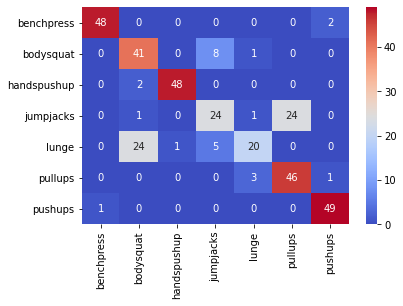

In [ ]:
sns.heatmap(confused_matrix,cmap='coolwarm',linecolor='white',xticklabels=target_names,yticklabels=target_names,annot=True)

In [ ]:
rgbs=np.hstack([
                np.argmax(rgb_bench_press,axis=1),
                np.argmax(rgb_body_squat,axis=1),
                np.argmax(rgb_handspushups,axis=1),
                np.argmax(rgb_jj,axis=1),
                np.argmax(rgb_lunges,axis=1),
                np.argmax(rgb_pullups,axis=1),
                np.argmax(rgb_pushups,axis=1),
])

In [ ]:
flow=np.hstack([
                np.argmax(flow_bench_press,axis=1),
                np.argmax(flow_body_squat,axis=1),
                np.argmax(flow_handspushups,axis=1),
                np.argmax(flow_jj,axis=1),
                np.argmax(flow_lunges,axis=1),
                np.argmax(flow_pullups,axis=1),
                np.argmax(flow_pushups,axis=1),
])

In [ ]:
flow.shape

(700,)

In [ ]:
rgbs

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [ ]:
con_matrix=confusion_matrix(trues,rgbs)
con_matrix

array([[100,   0,   0,   0,   0,   0,   0],
       [  0, 100,   0,   0,   0,   0,   0],
       [  0,  26,  74,   0,   0,   0,   0],
       [  0,  20,   0,  75,   0,   5,   0],
       [  1,   1,   0,   0,  77,   0,  21],
       [  0,   0,   0,   0,   0, 100,   0],
       [  0,   0,   0,   0,   0,   0, 100]])

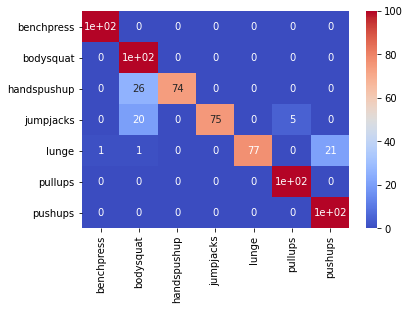

In [ ]:
sns.heatmap(con_matrix,cmap='coolwarm',linecolor='white',xticklabels=target_names,yticklabels=target_names,annot=True)

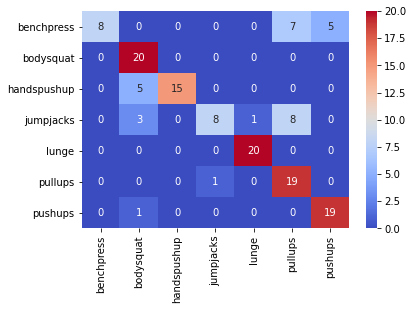

In [ ]:
sns.heatmap(con_matrix,cmap='coolwarm',linecolor='white',xticklabels=target_names,yticklabels=target_names,annot=True)